In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
import tensorflow as tf

In [14]:
image_dir = Path('./Datasets/shapes')

In [15]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split((os.path.split(x)[0]))[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images_df = pd.concat([filepaths, labels], axis=1)
train_df, test_df = train_test_split(images_df, train_size=0.7, shuffle=True, random_state=0)

In [16]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [17]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation'
)

test_images = train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

Found 168 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.


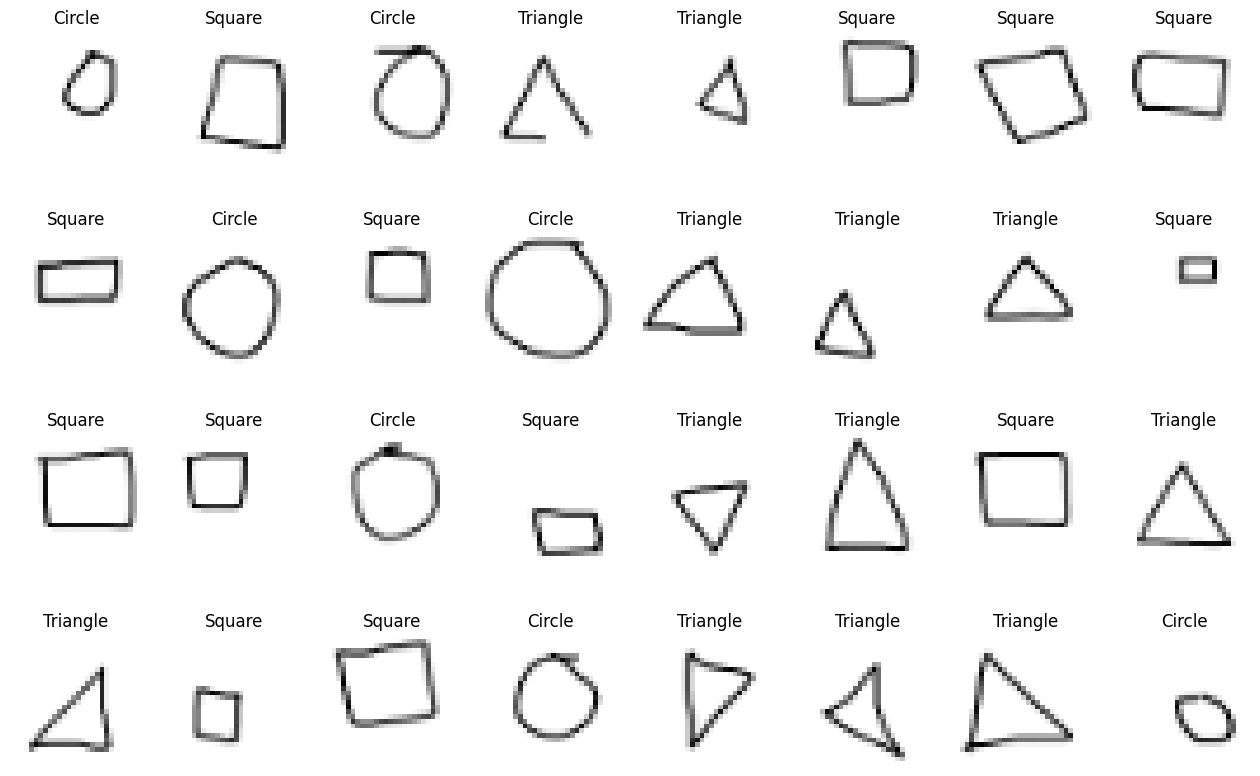

In [18]:
images = train_images[0][0]
labels = pd.Series(map(lambda x: x.argmax(), train_images[0][1][:])).map(
    {0: "Circle", 1: "Square", 2:"Triangle"})
    

plt.figure(figsize=(16, 10))

for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

In [19]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True, save_weights_only=True)
    ]
)

model.save('./full_model.h5')
print("Model has been saved as 'full_model.h5'")

Epoch 1/100
6/6 [==============================] - 1s 68ms/step - loss: 1.1016 - accuracy: 0.3452 - val_loss: 1.0961 - val_accuracy: 0.3333
Epoch 2/100
6/6 [==============================] - 0s 30ms/step - loss: 1.0970 - accuracy: 0.3512 - val_loss: 1.0977 - val_accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - 0s 29ms/step - loss: 1.0976 - accuracy: 0.3690 - val_loss: 1.0991 - val_accuracy: 0.2857
Epoch 4/100
6/6 [==============================] - 0s 31ms/step - loss: 1.0966 - accuracy: 0.4226 - val_loss: 1.0939 - val_accuracy: 0.3333
Epoch 5/100
6/6 [==============================] - 0s 35ms/step - loss: 1.0935 - accuracy: 0.3512 - val_loss: 1.0915 - val_accuracy: 0.3333
Epoch 6/100
6/6 [==============================] - 0s 33ms/step - loss: 1.0926 - accuracy: 0.3512 - val_loss: 1.0875 - val_accuracy: 0.3333
Epoch 7/100
6/6 [==============================] - 0s 34ms/step - loss: 1.0885 - accuracy: 0.3512 - val_loss: 1.0831 - val_accuracy: 0.3333
Epoch 8/100
6/6 [===

In [21]:
results = model.evaluate(test_images, verbose=0)
print("Loss: {:.4f}".format(results[0]))
print("Accuracy: {:.2f} %".format(results[1] * 100))

Loss: 0.3924
Accuracy: 83.33 %


In [29]:
import tensorflow as tf
import numpy as np
from keras.preprocessing import image

model = tf.keras.models.load_model('./full_model.h5')

def predict_image_class(model, img_path, target_size=(28, 28)):
    
    img = image.load_img(img_path, target_size=target_size, color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0 
    img_array = np.expand_dims(img_array, axis=0)  
 
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class[0]

# image_path = './Datasets/shapes/triangles/drawing(9).png'
image_path = './circle.jpg'  
predicted_class = predict_image_class(model, image_path)
print(f"Predicted class: {predicted_class}")


Predicted class: 2
